In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 불러오기
df = pd.read_csv("result/survey_responses.csv")

likert_cols = [
    "mental_demand","temporal_demand","performance","effort","frustration",
    "exploration","engagement","effort_reward","transparency","expressiveness",
    "dg1_clarity","dg2_prompt_to_image","dg2_image_to_prompt",
    "dg3_reusability","dg3_selective_edit"
 ]

plt.rcParams['font.family'] = 'AppleGothic'  # 한글 폰트 예시
plt.rcParams['font.size'] = 10

def plot_likert_responses(likert_cols, title="Likert Responses by System"):
    reverse_items = ["mental_demand", "temporal_demand", "effort", "frustration"]

    # long-format 변환
    likert_counts = df.melt(id_vars="system_type", value_vars=likert_cols, 
                            var_name="question", value_name="response")
    likert_counts["response"] = pd.to_numeric(likert_counts["response"], errors="coerce")

    # 각 system_type, question 별로 1~7 분포 비율 계산
    likert_counts = (
        likert_counts.groupby(["system_type","question","response"])
        .size().reset_index(name="count")
    )
    likert_counts["percent"] = likert_counts.groupby(["system_type","question"])["count"].transform(lambda x: x / x.sum() * 100)

    # 색상 팔레트 (1~7)
    colors = ["#8b0000","#cd5c5c","#f4cccc","#f2f2f2","#d9ead3","#6aa84f","#274e13"]

    # 플롯
    fig, axes = plt.subplots(len(likert_cols), 1, figsize=(8, 0.8*len(likert_cols)), sharex=True)

    for i, q in enumerate(likert_cols):
        ax = axes[i]
        bottoms = {"Baseline": 0, "OOPT": 0}
        responses_sorted = sorted(likert_counts["response"].dropna().unique())
        if q in reverse_items:
            palette = colors[::-1]  # 초록~빨강
            # responses_sorted는 1~7, palette는 초록~빨강: zip하면 1-초록, 7-빨강
            for resp, color in zip(responses_sorted, palette):
                for sys in ["OOPT","Baseline"]:
                    val = likert_counts[(likert_counts["system_type"]==sys) & 
                                        (likert_counts["question"]==q) & 
                                        (likert_counts["response"]==resp)]["percent"]
                    val = val.iloc[0] if not val.empty else 0
                    # 오른쪽에서 왼쪽으로 누적
                    ax.barh(sys + " (" + q + ")", val, left=100-bottoms[sys]-val, color=color)
                    if val > 0:
                        ax.text(100-bottoms[sys]-val/2, sys + " (" + q + ")", str(resp), va='center', ha='center', color='black', fontsize=8)
                    bottoms[sys] += val
        else:
            palette = colors        # 빨강~초록
            for resp, color in zip(responses_sorted, palette):
                for sys in ["OOPT","Baseline"]:
                    val = likert_counts[(likert_counts["system_type"]==sys) & 
                                        (likert_counts["question"]==q) & 
                                        (likert_counts["response"]==resp)]["percent"]
                    val = val.iloc[0] if not val.empty else 0
                    ax.barh(sys + " (" + q + ")", val, left=bottoms[sys], color=color)
                    if val > 0:
                        ax.text(bottoms[sys] + val/2, sys + " (" + q + ")", str(resp), va='center', ha='center', color='black', fontsize=8)
                    bottoms[sys] += val
        ax.set_ylabel("")

    axes[-1].set_xlabel("Percentage (%)")
    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


In [25]:
TLX_likert_cols = [
    "mental_demand","temporal_demand","performance","effort","frustration",
]

CSI_likert_cols = [
     "exploration","engagement","effort_reward","transparency","expressiveness",
]

Sys_likert_cols = [
    "dg1_clarity","dg2_prompt_to_image","dg2_image_to_prompt",
    "dg3_reusability","dg3_selective_edit"
]


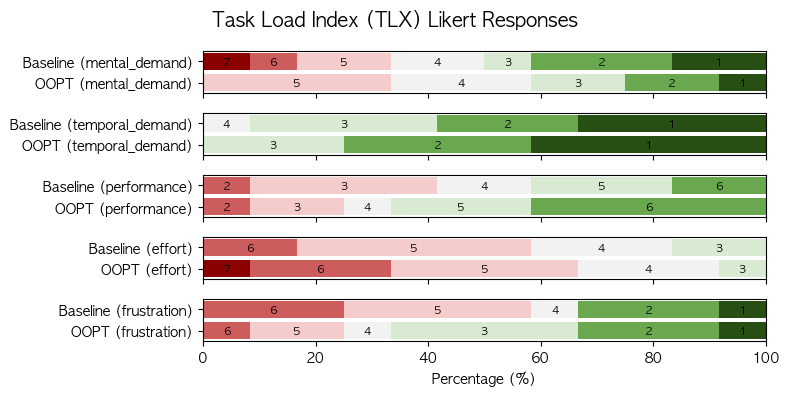

In [26]:
plot_likert_responses(TLX_likert_cols, "Task Load Index (TLX) Likert Responses")

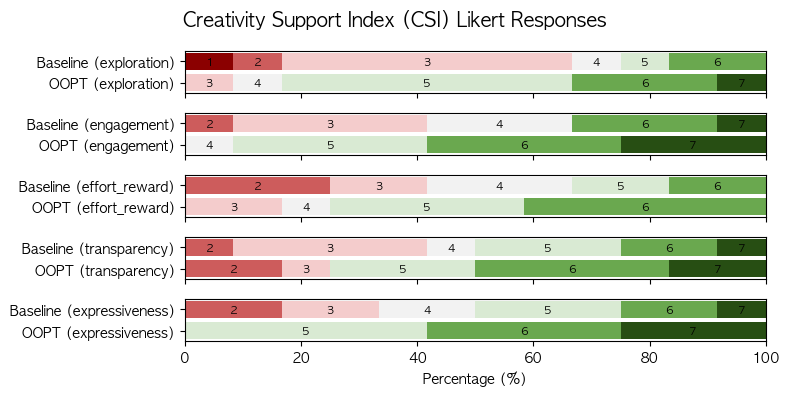

In [27]:
plot_likert_responses(CSI_likert_cols, "Creativity Support Index (CSI) Likert Responses")

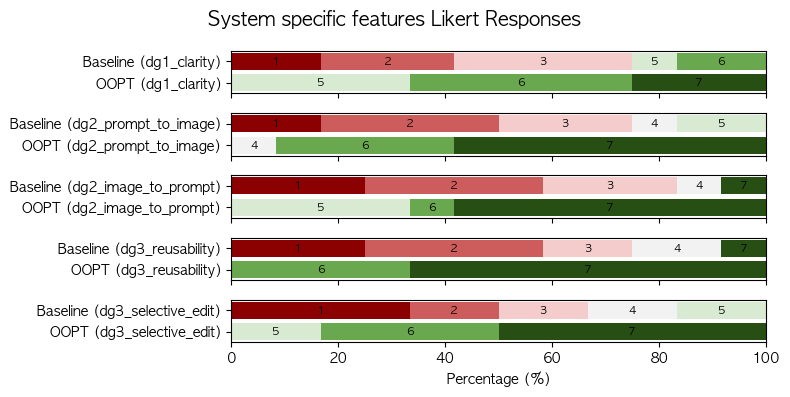

In [28]:
plot_likert_responses(Sys_likert_cols, "System specific features Likert Responses")

In [45]:
def survey_boot_ci(likert_cols):
    reverse_items = {"mental_demand","temporal_demand","effort","frustration"}

    def orient_scores(s, name):
        v = pd.to_numeric(s, errors="coerce")
        return 8 - v if name in reverse_items else v

    X = df.copy()
    for c in likert_cols:
        X[c] = orient_scores(X[c], c)

    # 부트스트랩 CI
    def boot_ci(x, n=3000, alpha=0.05):
        x = pd.to_numeric(x, errors="coerce").dropna().values
        if len(x)==0: return (np.nan, np.nan)
        boots = np.random.choice(x, (n, len(x)), True).mean(axis=1)
        return np.percentile(boots, [100*alpha/2, 100*(1-alpha/2)])

    means = X.groupby("system_type")[likert_cols].mean().T
    cis = {sys: X[X.system_type==sys][likert_cols].apply(lambda col: boot_ci(col), axis=0)
        for sys in ["Baseline","OOPT"]}

    y = np.arange(len(likert_cols))
    plt.figure(figsize=(9, 0.6*len(likert_cols)))
    color_map = {"Baseline": "#1f77b4", "OOPT": "#ff7f0e"}
    for i,q in enumerate(likert_cols):
        m1, m2 = means.loc[q, "Baseline"], means.loc[q, "OOPT"]
        c1, c2 = cis["Baseline"][q], cis["OOPT"][q]
        # CI
        plt.plot(c1, [y[i]]*2, lw=4, solid_capstyle="round", color="#999999")
        plt.plot(c2, [y[i]]*2, lw=4, solid_capstyle="round", color="#999999")
        # mean 점
        plt.scatter([m1], [y[i]], s=36, zorder=3, color=color_map["Baseline"])
        plt.scatter([m2], [y[i]], s=36, zorder=3, color=color_map["OOPT"])
        # 덤벨 연결선
        plt.plot([m1, m2], [y[i], y[i]], color="#666", lw=1)

    plt.yticks(y, likert_cols)
    plt.xlabel("Mean score (higher is better; reversed for demand/effort/frustration)")
    # legend: 색상과 시스템명 직접 표시, 차트 오른쪽 바깥에 위치
    import matplotlib.lines as mlines
    handles = [
        mlines.Line2D([], [], color=color_map["Baseline"], marker='o', linestyle='None', markersize=8, label='Baseline'),
        mlines.Line2D([], [], color=color_map["OOPT"], marker='o', linestyle='None', markersize=8, label='OOPT'),
    ]
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
    plt.xlim(1,7)
    plt.tight_layout(); plt.show()


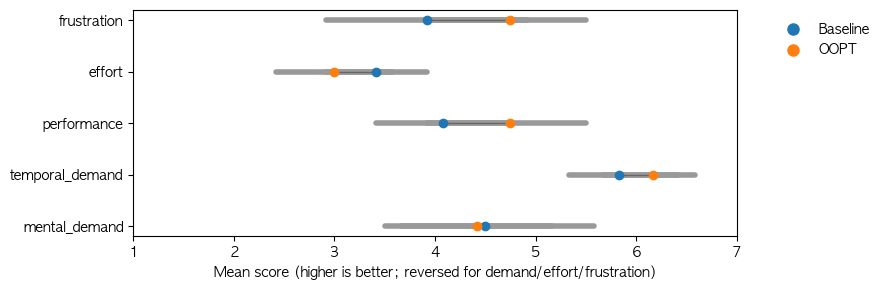

In [46]:
survey_boot_ci(TLX_likert_cols)

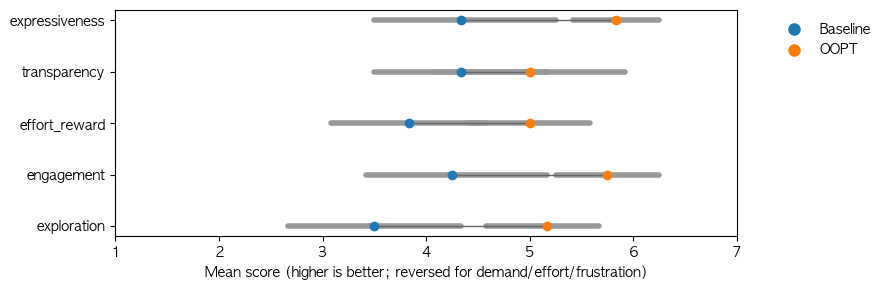

In [47]:
survey_boot_ci(CSI_likert_cols)

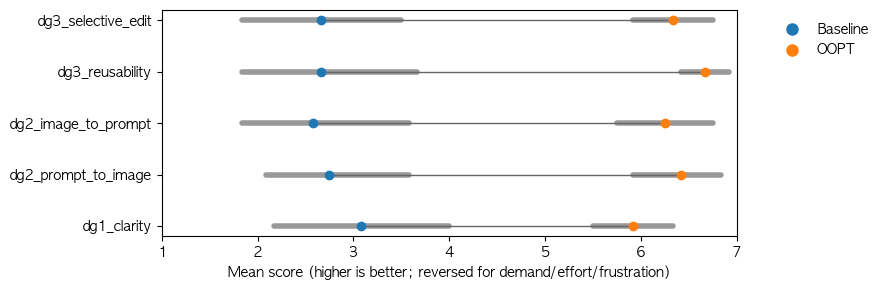

In [48]:
survey_boot_ci(Sys_likert_cols)